In [1]:
import yt
import numpy as np

In [37]:
# Parameters to modify
# resolution = 8192
resolution = 16384
box_width = 10 #Mpc
halo_radius = 70 #kpc
igm_vel = 0 #-80 #km/s negative means inflowing
halo_vel = 200 #km/s
igm_weight = 1/500 # relative weight to uniform IGM density versus halo density at r_vir

In [38]:
# initialize a 3D grid of uniform grid density (2D + 1 dimension in X)
arr = np.ones([1, resolution, resolution])
zeros = 0*arr
data = dict(test = (arr, 'g'))
bbox = np.array([[-box_width/2, box_width/2], [-box_width/2, box_width/2],
                 [-box_width/2, box_width/2]]) # bounding box
# Create the dataset in yt
ds = yt.load_uniform_grid(data, arr.shape, length_unit="Mpc", bbox=bbox, nprocs=64) #64
ad = ds.all_data()
c = [0,0,0] # center

# Virial radius and scale radius.  Acceptable values for scale radius are
# between 0.025 and 0.25 for actual galaxies fit with NFWs. We choose 0.25 to
# maximize mass in halo.
r_vir = ds.quan(halo_radius, 'kpc')
r_scale = (0.25 * r_vir).in_units('cm').v
r_scale3 = r_scale**3

# Add in additional fields: density, velocity, etc.
# Each field will have two components, one for the background IGM, the other
# for the halo.
def _density(field, data):
    halo = data['radius'] <= r_vir
    # uniform density beyond r_vir
    vals = igm_weight * data.ds.arr(data['ones'], 'g/cm**3') / ((r_vir.in_units('cm').v/r_scale) * (1 + r_vir.in_units('cm').v/r_scale)**2)
    # NFW density for halo: r_scale is 25% of r_vir
    vals[halo] = 1/((data['radius'][halo].v/r_scale) * (1 + data['radius'][halo].v/r_scale)**2)
    return vals
ds.add_field(("gas", "density"), function=_density, units="g/cm**3", sampling_type='cell')

# x velocity component
def _x_velocity(field, data):
    halo = data['radius'] <= r_vir
    vals = data.ds.arr(igm_vel*(data['x'] / data["radius"]).v, 'km/s')
    vals[halo] = data.ds.arr(halo_vel*(data['x'][halo] / data["radius"][halo]).v, 'km/s')
    return vals
ds.add_field(("gas", "velocity_x"), function=_x_velocity, units="km/s", sampling_type='cell')

# y velocity component
def _y_velocity(field, data):
    halo = data['radius'] <= r_vir
    vals = data.ds.arr(igm_vel*(data['y'] / data["radius"]).v, 'km/s')
    vals[halo] = data.ds.arr(halo_vel*(data['y'][halo] / data["radius"][halo]).v, 'km/s')
    return vals
ds.add_field(("gas", "velocity_y"), function=_y_velocity, units="km/s", sampling_type='cell')

# z velocity component
def _z_velocity(field, data):
    halo = data['radius'] <= r_vir
    vals = data.ds.arr(igm_vel*(data['z'] / data["radius"]).v, 'km/s')
    vals[halo] = data.ds.arr(halo_vel*(data['z'][halo] / data["radius"][halo]).v, 'km/s')
    return vals
ds.add_field(("gas", "velocity_z"), function=_z_velocity, units="km/s", sampling_type='cell')

# total velocity magnitude
def _total_velocity(field, data):
    return np.sqrt(data['velocity_x']**2 + data['velocity_y']**2 + data['velocity_z']**2)
ds.add_field(("gas", "velocity_magnitude"), function=_total_velocity, units="km/s", sampling_type='cell')

# column density for a cell
def _column_density(field, data):
    return data['density'] * data['dz']
ds.add_field(("gas", "column_density"), function=_column_density, units="g/cm**2", sampling_type='cell')

# add an impact parameter field assuming center = 0,0,0
def _impact_parameter(field, data):
    return np.sqrt(data["x"]**2 + data["y"]**2)
ds.add_field(("index", "impact_parameter"), function=_impact_parameter, units="kpc", sampling_type='cell')

# Add a cosmological line of sight velocity field
H_2 = ds.quan(200, 'km/s/Mpc')
def _v_cosmo(field, data):
    return H_2*data['z']
ds.add_field(("gas", "velocity_cosmo"), function=_v_cosmo, units="km/s", sampling_type='cell')

# Make an effective LOS velocity field, which is a combination of the true LOS
# velocity (z velocity) and the hubble velocity (H * D_z) = hubble parameter at
# redshift 2 ~ 200 km/s * the distance in z direction from galaxy.
# in this case, it is somewhat simplified because the galaxy sits at the origin
# and has zero velocity.

# Remember there is a cross term because this is at z=2, so line of sight
# velocity is actually 3*velocity_z + cosmological velocity
def _v_los(field, data):
    return 3*data['velocity_z'] + H_2*data['z']
ds.add_field(("gas", "velocity_los"), function=_v_los, units="km/s", sampling_type='cell')

yt : [INFO     ] 2024-07-02 16:21:15,188 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-07-02 16:21:15,192 Parameters: domain_dimensions         = [    1 16384 16384]
yt : [INFO     ] 2024-07-02 16:21:15,195 Parameters: domain_left_edge          = [-5. -5. -5.]
yt : [INFO     ] 2024-07-02 16:21:15,199 Parameters: domain_right_edge         = [5. 5. 5.]
yt : [INFO     ] 2024-07-02 16:21:15,202 Parameters: cosmological_simulation   = 0


In [4]:
# Plot a top-down view of the field in density and overlay the velocity vectors
s = yt.SlicePlot(ds, "x", ('gas', 'density'), center=c, data_source=ad, width=(500, 'kpc'))
s.set_cmap("density", "Blues")
s.annotate_marker(c)
s.annotate_quiver('velocity_y', 'velocity_z', factor=12)#, plot_args={"color":"red"})
s.save('doppler.png')
s.clear_annotations()
s.annotate_marker(c)
s.annotate_quiver('zeros', 'velocity_cosmo', factor=12)#, plot_args={"color":"green"})
s.save('cosmo.png')
s.clear_annotations()
s.annotate_marker(c)
s.annotate_quiver('velocity_y', 'velocity_los', factor=12)#, plot_args={"color":"black"})
s.save('cosmo_doppler.png')

yt : [INFO     ] 2024-07-02 14:15:09,207 xlim = -0.250000 0.250000
yt : [INFO     ] 2024-07-02 14:15:09,208 ylim = -0.250000 0.250000
yt : [INFO     ] 2024-07-02 14:15:09,209 xlim = -0.250000 0.250000
yt : [INFO     ] 2024-07-02 14:15:09,210 ylim = -0.250000 0.250000
yt : [INFO     ] 2024-07-02 14:15:09,216 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2024-07-02 14:15:10,774 Saving plot doppler.png
yt : [INFO     ] 2024-07-02 14:15:11,548 Saving plot cosmo.png
yt : [INFO     ] 2024-07-02 14:15:12,304 Saving plot cosmo_doppler.png


['cosmo_doppler.png']

yt : [INFO     ] 2024-07-02 14:15:21,212 xlim = -0.250000 0.250000
yt : [INFO     ] 2024-07-02 14:15:21,212 ylim = -0.250000 0.250000
yt : [INFO     ] 2024-07-02 14:15:21,214 xlim = -0.250000 0.250000
yt : [INFO     ] 2024-07-02 14:15:21,215 ylim = -0.250000 0.250000
yt : [INFO     ] 2024-07-02 14:15:21,220 Making a fixed resolution buffer of (('gas', 'column_density')) 800 by 800
yt : [INFO     ] 2024-07-02 14:15:21,672 Saving plot N_vs_z.png



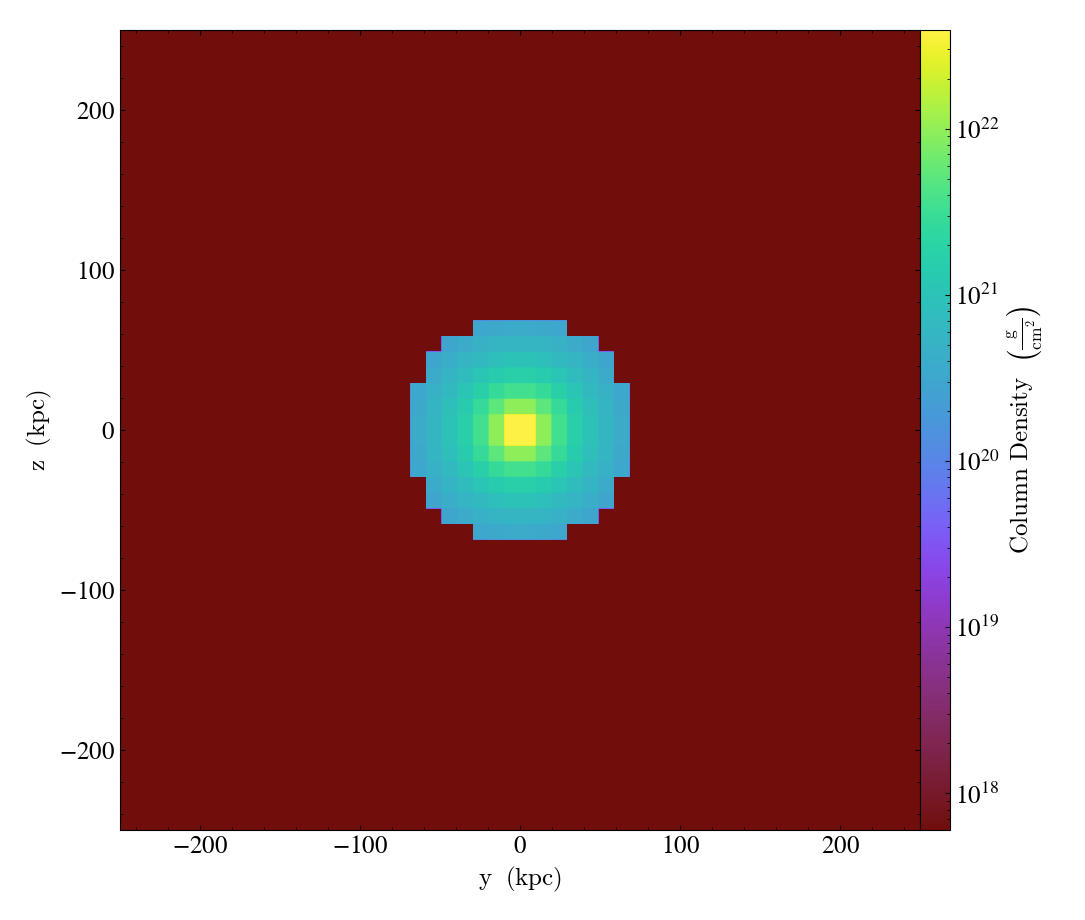

In [5]:
p = yt.SlicePlot(ds, "x", ('gas', 'column_density'), center=c, data_source=ad, width=(500, 'kpc'))
p.save('N_vs_z.png')
p.show()

yt : [INFO     ] 2024-07-02 14:15:32,042 Saving plot rho_vs_r_1d-Profile_z_column_density.png



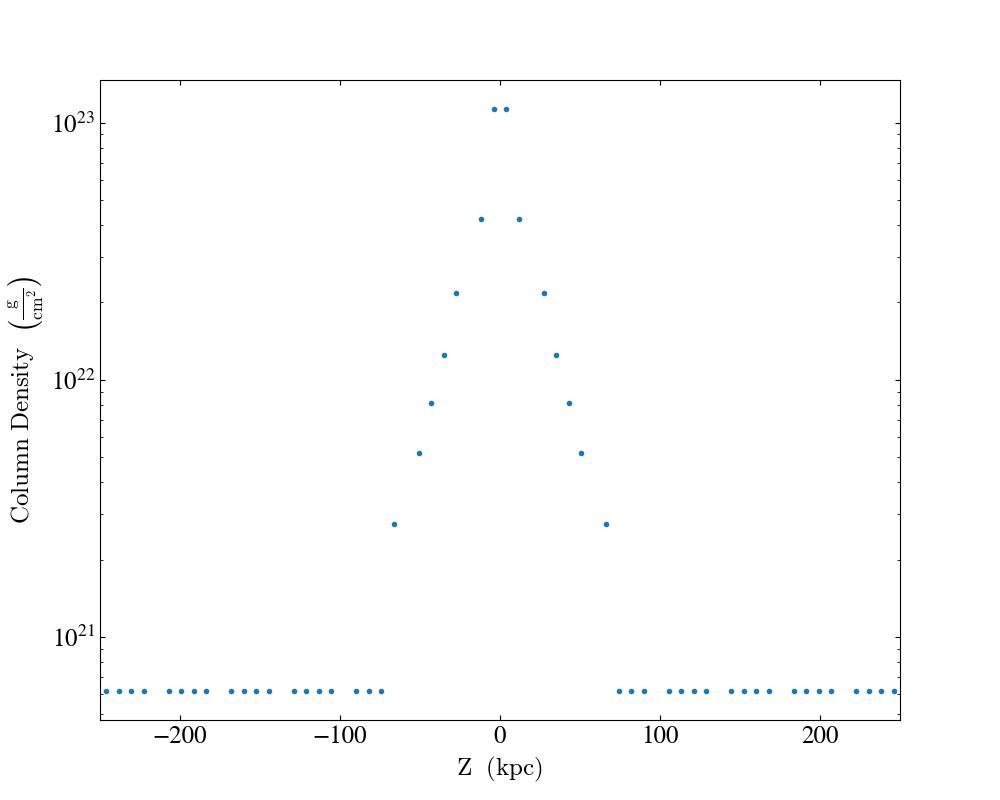

In [6]:
# ('index', 'z')
p = yt.ProfilePlot(ad, 'z', ('gas', 'column_density'), weight_field=None, plot_spec=dict(marker='.', linestyle='None', alpha=1))
p.set_unit('z', 'kpc')
p.set_xlim(-250, 250)
p.save('rho_vs_r.png')
p.show()


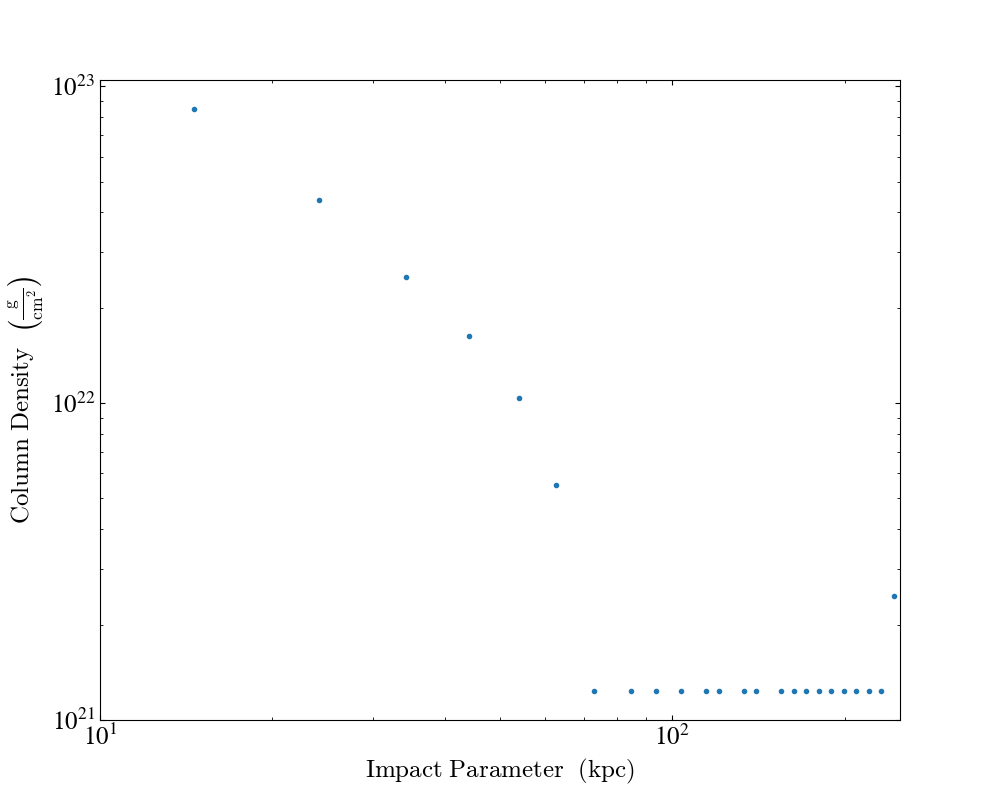

In [7]:
p = yt.ProfilePlot(ad, ("index", "impact_parameter"), ('gas', 'column_density'), weight_field=None, plot_spec=dict(marker='.', linestyle='None', alpha=1))
p.set_unit(("index", "impact_parameter"), 'kpc')
p.set_xlim(10, 250)
# p.save('rho_vs_r.png')
p.show()


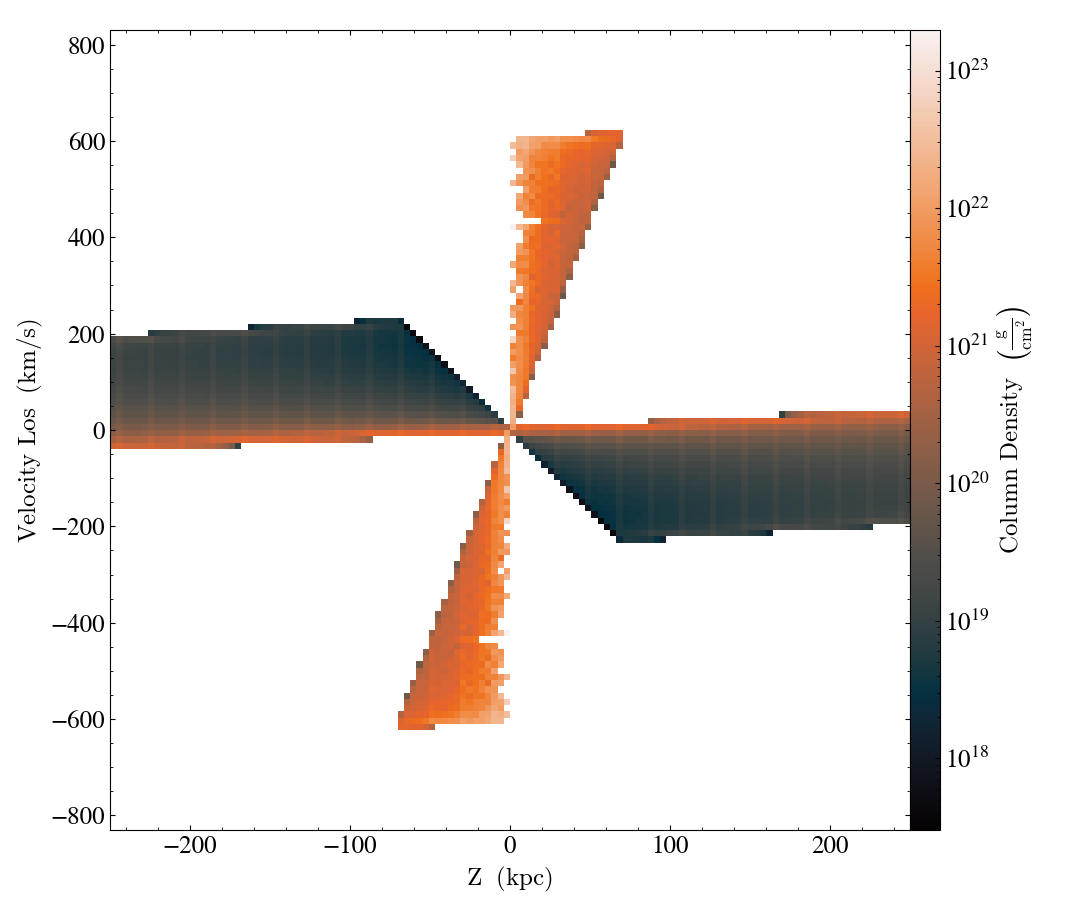

In [31]:
phase = yt.PhasePlot(ad, ('index', "z"), ('gas', "velocity_los"), ["column_density"], weight_field=None)
phase.set_log('velocity_los', False)
phase.set_log(('index','z'), False)
phase.set_unit(('index', 'z'), 'kpc')
phase.set_xlim(-250, 250)
# phase.set_ylim(-1500, 1500)
phase.set_cmap('column_density', 'dusk')
# phase.save('phase.png')
phase.show()


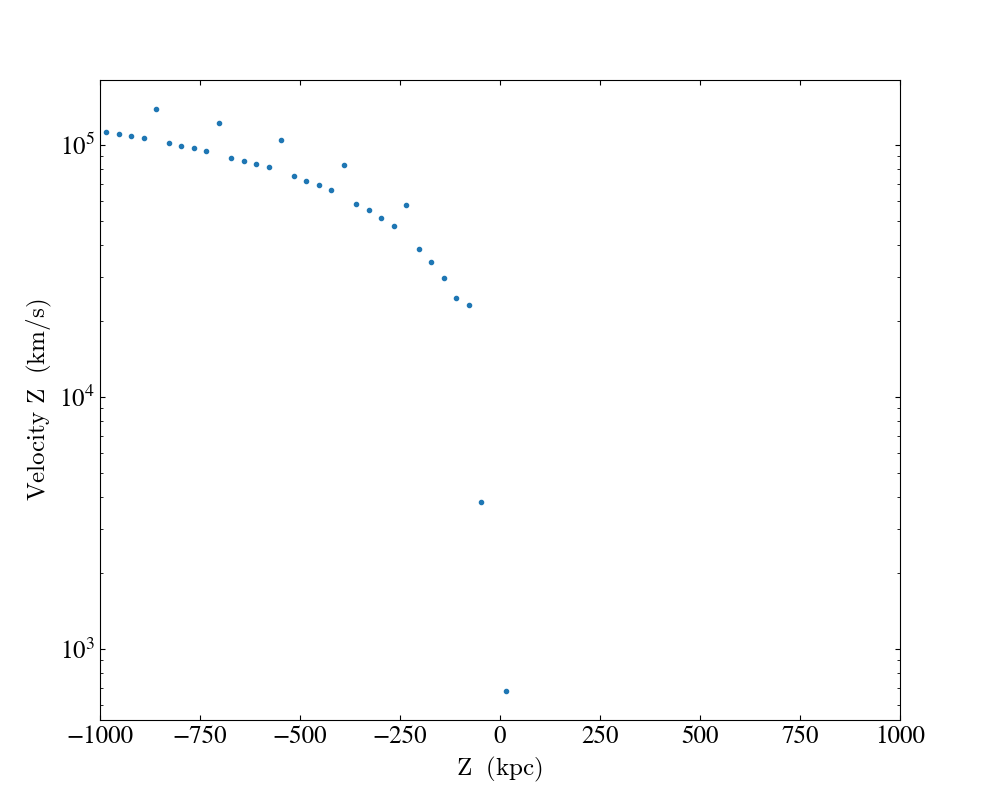

In [28]:
p = yt.ProfilePlot(ad, ("index", "z"), ("gas", "velocity_z"), weight_field=None, plot_spec=dict(marker='.', linestyle='None', alpha=1))
p.set_unit(("index", "z"), 'kpc')
p.set_xlim(-1000, 1000)
# p.save('rho_vs_r.png')
p.show()

yt : [INFO     ] 2024-07-02 17:08:44,743 Saving plot phase.png



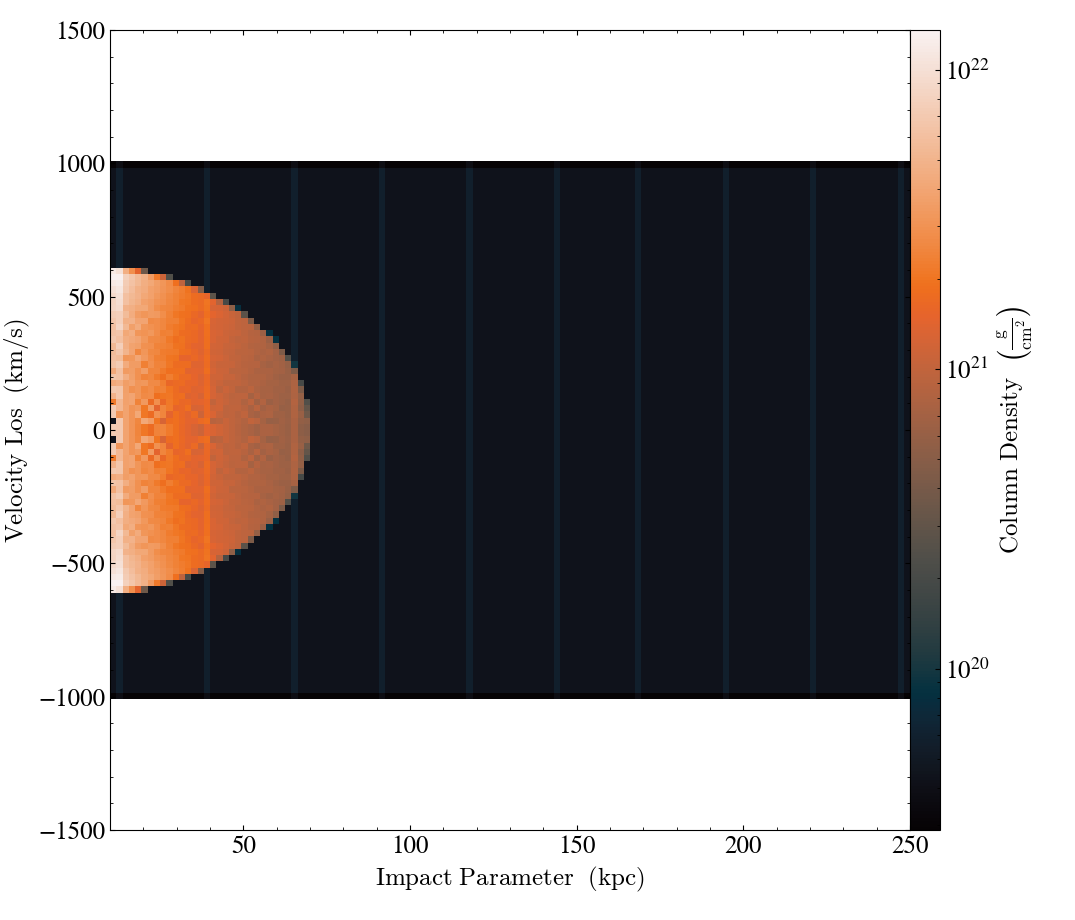

In [39]:
# make a phase plot comparing impact parameter to effective LOS velocity
phase = yt.PhasePlot(ad, ('index', "impact_parameter"), ('gas', "velocity_los"), ["column_density"], weight_field=None)
phase.set_log('velocity_los', False)
phase.set_log(('index', 'impact_parameter'), False)
phase.set_xlim(10, 250)
phase.set_ylim(-1500, 1500)
phase.set_cmap('column_density', 'dusk')
phase.save('phase.png')
phase.show()


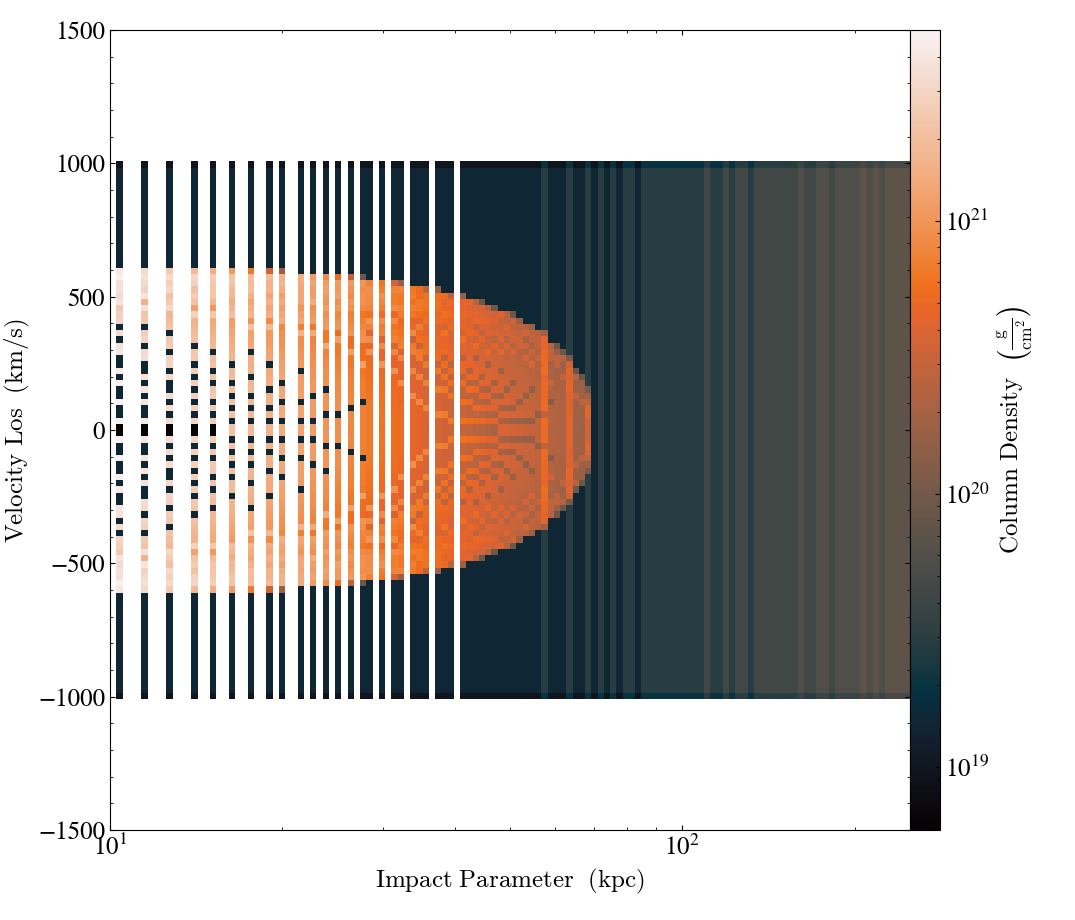